# 数据归档

## 配置信息

In [6]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import numpy as np
import os
pymysql.install_as_MySQLdb()

# 修改当前主目录
os.chdir(r'C:/Users/yves1/Desktop/')

# SKU配置信息
sku_data = pd.read_json(r'D:\GitHub\Iridescent\Dataset\sku_data.json')

# 数据库配置信息
db_engine = str(r'mysql+mysqldb://%s:' + '%s' + '@%s/%s') % (sku_data.loc['USER', 'Data'], sku_data.loc['PWD', 'Data'], sku_data.loc['IP', 'Data'], sku_data.loc['DB', 'Data'])

# 表名信息
shark_gray_business_us = 'tbl_shark_gray_business_us'
shark_gray_ad_us = 'tbl_shark_gray_ad_us'
shark_gray_statistical_us = 'tbl_shark_gray_statistical_us'
amorun_business_us = 'tbl_amorun_business_us'
amorun_ad_us = 'tbl_amorun_ad_us'
amorun_statistical_us = 'tbl_amorun_statistical_us'

## 业务报表

In [2]:
def parse_business_report(date, table_name):
    business_report = pd.read_csv(next(value for value in os.listdir() if value.startswith('BusinessReport')))
    business_report.drop(['Title', 'Session Percentage', 'Page Views Percentage'], axis=1, inplace=True)
    business_report.rename({'(Child) ASIN': 'SKU'}, axis=1, inplace=True)
    business_report['SKU'] = business_report['SKU'].apply(lambda x: sku_data.loc[x.strip(), 'Data'])
    business_report.insert(loc=0, column='Date', value=pd.to_datetime(date, format='%Y/%m/%d'))
    engine = create_engine(db_engine)
    try:
        business_report.to_sql(table_name, engine, if_exists='append', index=False)
    except Exception as e:
        print(e)
    finally:
        engine.dispose()

## 广告报表

In [3]:
def parse_sponsored_report(date, table_name):
    sponsored_report = pd.read_excel(next(value for value in os.listdir() if value.startswith('Sponsored Products')))
    sponsored_report = sponsored_report[sponsored_report['Date']==date]
    sponsored_report.drop(['Currency', 'Ad Group Name', 'Total Return on Advertising Spend (RoAS)', '7 Day Advertised SKU Units (#)', '7 Day Other SKU Units (#)', '7 Day Advertised SKU Sales ', '7 Day Other SKU Sales '], axis=1, inplace=True)
    sponsored_report.rename({'Click-Thru Rate (CTR)': 'CTR', 'Cost Per Click (CPC)': 'CPC', '7 Day Total Sales ': 'Total Sales', 'Total Advertising Cost of Sales (ACoS) ': 'ACoS', '7 Day Total Orders (#)': 'Total Orders', '7 Day Total Units (#)': 'Total Units', '7 Day Conversion Rate': 'CR'}, axis=1, inplace=True)
    sponsored_report['ACoS'].fillna(value=0, inplace=True)
    sponsored_report[['CTR', 'CPC', 'ACoS', 'CR']] = sponsored_report[['CTR', 'CPC', 'ACoS', 'CR']].apply(lambda x: round(x, 4))
    sponsored_report.sort_values(by=['Portfolio name', 'Campaign Name'], inplace=True)
    engine = create_engine(db_engine)
    try:
        sponsored_report.to_sql(table_name, engine, if_exists='append', index=False)
    except Exception as e:
        print(e)
    finally:
        engine.dispose()

In [6]:
date = '2020/12/29'
# 解析业务报表数据
parse_business_report(date, shark_gray_business_us)
# 解析赞助广告数据
parse_sponsored_report(date, shark_gray_ad_us)

# 数据统计

## 配置信息

In [2]:
product_name = {
    'B08BXTW512': 'Women`s Thongs',
    'B08GGBZLXQ': 'Men`s Boxer Briefs',
    'B08K8PR7DK': 'women yoga leggings',
    'B08M64C67V': 'men sweatshirt',
    'B08M5GH26F': 'women vest',
    'B08M5WMB78': 'women jacket',
    'B08M69KDVV': 'yoga mat'
}

## 运营数据报表

In [5]:
def generate_daily_report(date, table_name):
    try:
        # 数据查询
        engine = create_engine(db_engine)
        business_sql = 'select `Date`, `(Parent) ASIN`, `Sessions`, `Page Views`, `Units Ordered`, `Units Ordered - B2B`, `Ordered Product Sales`, `Ordered Product Sales - B2B`, `Total Order Items`, `Total Order Items - B2B` from `tbl_{}_business_{}` where Date(Date) = "{}"'.format(table_name[4: -15], table_name[-2: ], date)
        sponsored_sql = 'select `Date`, `Portfolio name`, `Clicks`, `Spend`, `Total Sales`, `Total Orders` from `tbl_{}_ad_{}` where Date(Date) = "{}"'.format(table_name[4: -15], table_name[-2: ], date)
        business_data = pd.read_sql_query(business_sql, engine)
        sponsored_data = pd.read_sql_query(sponsored_sql, engine)
        # 数据清洗
        business_data.iloc[:, 1] = business_data.iloc[:, 1].apply(lambda x: product_name[x])
        business_data.rename({'(Parent) ASIN': 'Product'}, axis=1, inplace=True)
        business_data.iloc[:, [6, 7]] = business_data.iloc[:, [6, 7]].apply(lambda x: x.str.replace('$', '')).astype('float')
        # 数据聚合
        business_total = business_data.groupby('Product')[['Sessions', 'Page Views', 'Units Ordered', 'Units Ordered - B2B', 'Ordered Product Sales', 'Ordered Product Sales - B2B', 'Total Order Items', 'Total Order Items - B2B']].sum()
        sponsored_total = sponsored_data.groupby('Portfolio name')[['Clicks', 'Spend', 'Total Sales', 'Total Orders']].sum()
        total = pd.concat([business_total, sponsored_total], axis = 1, keys=['business_total', 'sponsored_total'])
        total.columns = total.columns.droplevel()
        total.reset_index(level=0, inplace=True)
        # 数据统计
        total.insert(loc=0, column='Date', value=pd.to_datetime(date, format='%Y/%m/%d'))
        total.rename({'index': 'Product', 'Sessions': 'UV', 'Page Views': 'PV', 'Units Ordered': 'Order', 'Units Ordered - B2B': 'Order-B2B', 'Ordered Product Sales': 'Sales', 'Ordered Product Sales - B2B': 'Sales-B2B', 'Total Order Items': 'Items', 'Total Order Items - B2B': 'Items-B2B', 'Total Sales': 'Sales-AD', 'Total Orders': 'Order-AD'}, axis=1, inplace=True)
        total['Depth Factor'] = round(total['PV']/total['UV'], 4)
        total['AD Traffic Share'] = round(total['Clicks']/total['UV'], 4)
        total['AD Order Share'] = round(total['Order-AD']/(total['Order'] + total['Order-B2B']), 4)
        total['AD Sales Share'] = round(total['Sales-AD']/(total['Sales'] + total['Sales-B2B']), 4)
        total['ACoS'] = round(total['Spend']/total['Sales-AD'], 4)
        total['Overall ACoS'] = round(total['Spend']/(total['Sales'] + total['Sales-B2B']), 4)
        total['CR'] = round(total['Order']/total['UV'], 4)
        total['AD CR'] = round(total['Order-AD']/total['UV'], 4)
        total['SAE'] = round(0.85*(total['Sales'] + total['Sales-B2B']) - total['Spend'] - 4*(total['Order'] + total['Order-B2B']), 4)
        total[['Sales', 'Sales-B2B', 'Spend', 'Sales-AD']] = total[['Sales', 'Sales-B2B', 'Spend', 'Sales-AD']].apply(lambda x: round(x, 4))
        total.replace([np.inf, -np.inf], 0, inplace=True)
        total.fillna(value=0, inplace=True)
        # 输出到本地查看
        total.to_csv('data_{}.csv'.format(date.replace('/', '')), index=False)
        # 数据存档
        total.to_sql(table_name, engine, if_exists='append', index=False)
    except Exception as e:
        print(e)
    finally:
        engine.dispose()

In [7]:
generate_daily_report('2020/12/29', shark_gray_statistical_us)

# 运营数据分析

## 配置信息

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 数据查询函数
def query_statistical_data(table_name, product, start_date, end_date):
    try:
        engine = create_engine(db_engine)
        statistical_sql = 'select `Date`, `Product`, `UV`, `PV`, `Order`, `Order-B2B`, `Sales`, `Sales-B2B`, `Items`, `Items-B2B`, `Clicks`, `Spend`, `Sales-AD`, `Order-AD`, `Depth Factor`, `AD Traffic Share`, `AD Order Share`, `AD Sales Share`, `ACoS`, `Overall ACoS`, `CR`, `AD CR`, `SAE` from tbl_{}_statistical_{} where `Product`="{}" and Date(Date) between "{}" and "{}"'.format(table_name[4: -15], table_name[-2: ], product, start_date, end_date)
        return pd.read_sql_query(statistical_sql, engine)
    except Exception as e:
        print(e)
    finally:
        engine.dispose()

# 折线图作图函数
def folded_line(x, y, title, xlabel='日期', ylabel='数量'):
    fig = plt.figure(figsize=(20, 10))
    for item in y:
        plt.plot(x, item[0], label=item[1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # 获取图坐标信息
    ax = plt.gca()
    # 设置x轴每个刻度的间隔天数
    xlocator = mpl.ticker.MultipleLocator(1)
    ax.xaxis.set_major_locator(xlocator)
    # 为了避免x轴日期刻度标签的重叠设置x轴刻度自动展现并且45度倾斜
    fig.autofmt_xdate(rotation = 45)
    plt.legend()
    plt.show()

In [8]:
# 查询数据
start_date = '2020/12/1'
end_date = '2020/12/29'
product = 'women yoga leggings'
statistical_data = query_statistical_data(shark_gray_statistical_us, product, start_date, end_date)

## 基本信息概览

In [29]:
statistical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
UV,28.0,28.642857,14.013788,3.0000,18.250000,29.50000,37.250000,66.0000
PV,28.0,42.571429,33.738020,5.0000,22.500000,35.50000,50.250000,141.0000
Order,28.0,3.928571,2.552103,1.0000,2.000000,3.00000,5.250000,10.0000
Order-B2B,28.0,0.071429,0.262265,0.0000,0.000000,0.00000,0.000000,1.0000
Sales,28.0,47.251429,32.251644,13.7900,17.605000,36.86500,61.500000,123.9400
Sales-B2B,28.0,1.142143,4.193622,0.0000,0.000000,0.00000,0.000000,15.9900
Items,28.0,3.750000,2.413312,1.0000,2.000000,3.00000,5.250000,10.0000
Items-B2B,28.0,0.071429,0.262265,0.0000,0.000000,0.00000,0.000000,1.0000
Clicks,28.0,10.250000,2.518450,7.0000,8.000000,9.50000,13.000000,15.0000
Spend,28.0,11.619643,3.227527,6.1400,9.312500,11.11500,14.515000,17.0000


## 流量趋势

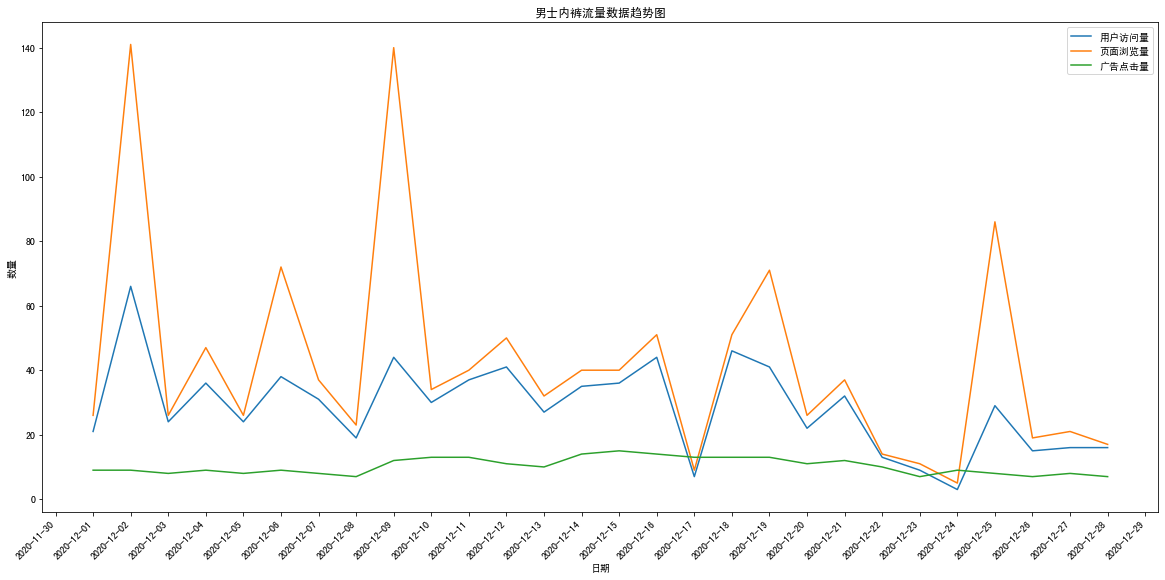

In [18]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['UV'], '用户访问量'], [statistical_data['PV'], '页面浏览量'], [statistical_data['Clicks'], '广告点击量']]
title = '男士内裤流量数据趋势图'
folded_line(x, y, title)

## 订单量趋势

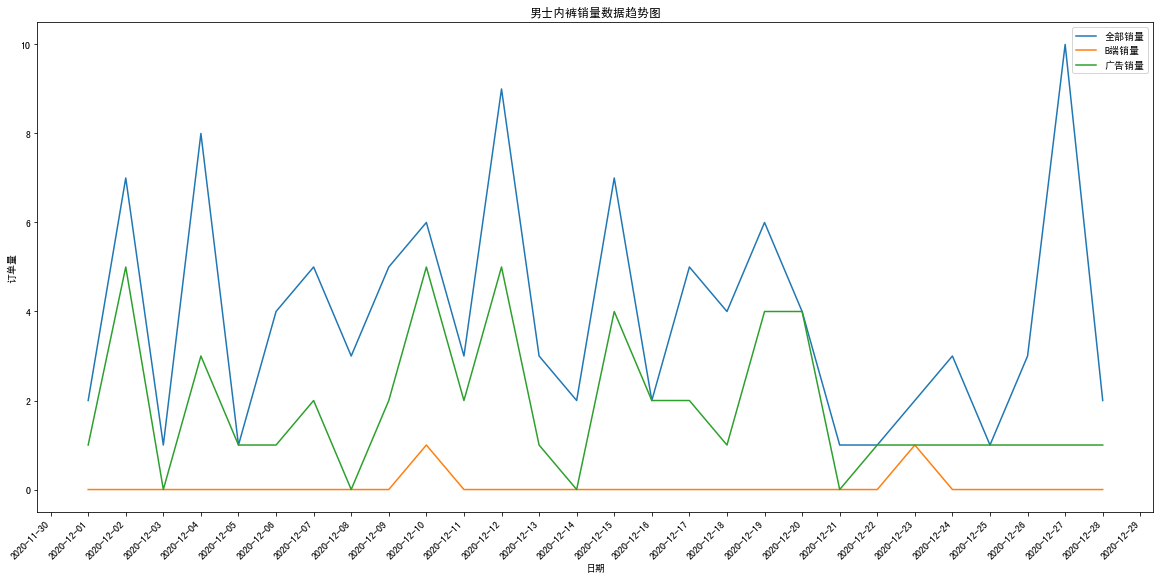

In [19]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['Order'], '全部销量'], [statistical_data['Order-B2B'], 'B端销量'], [statistical_data['Order-AD'], '广告销量']]
title = '男士内裤销量数据趋势图'
ylabel = '订单量'
folded_line(x, y, title, ylabel=ylabel)

## 销售额趋势

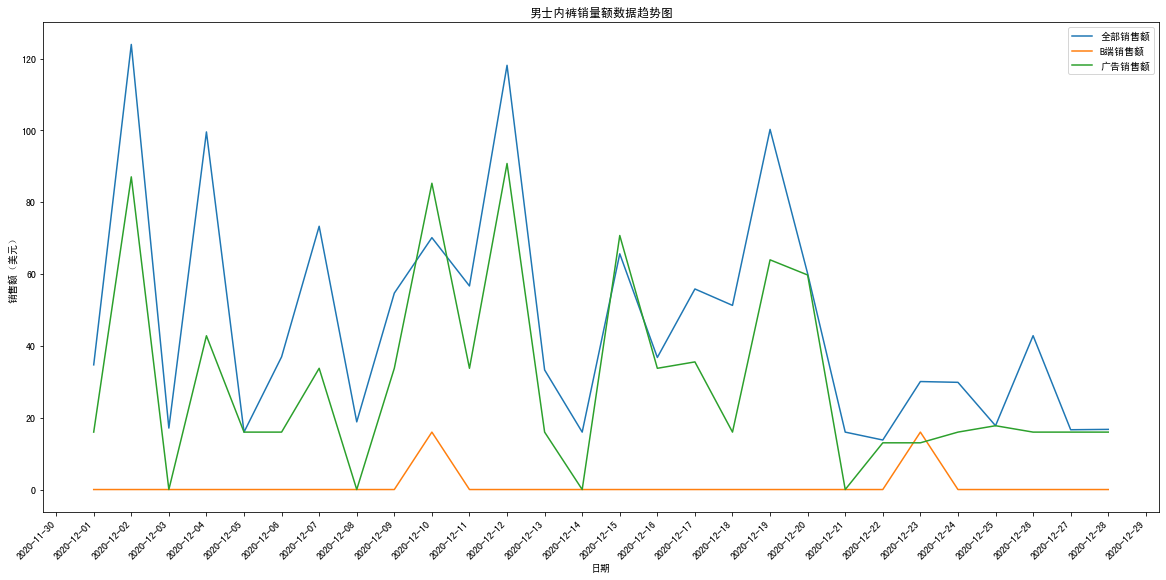

In [20]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['Sales'], '全部销售额'], [statistical_data['Sales-B2B'], 'B端销售额'], [statistical_data['Sales-AD'], '广告销售额']]
title = '男士内裤销量额数据趋势图'
ylabel = '销售额（美元）'
folded_line(x, y, title, ylabel=ylabel)

## 用户浏览习惯（跳失率）

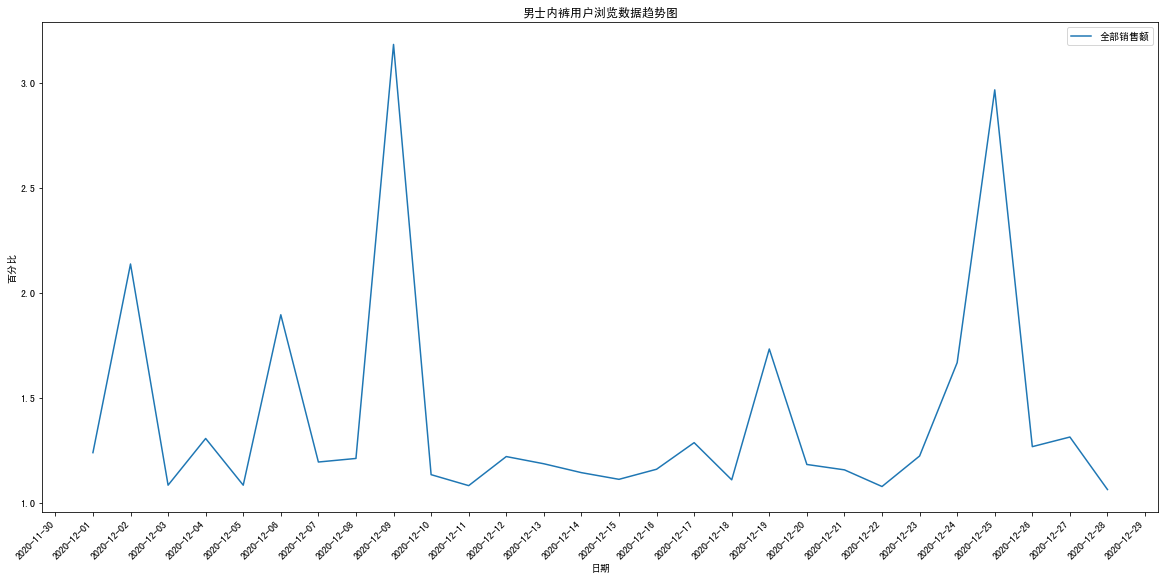

In [21]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['Depth Factor'], '全部销售额']]
title = '男士内裤用户浏览数据趋势图'
ylabel = '百分比'
folded_line(x, y, title, ylabel=ylabel)

## 广告表现情况

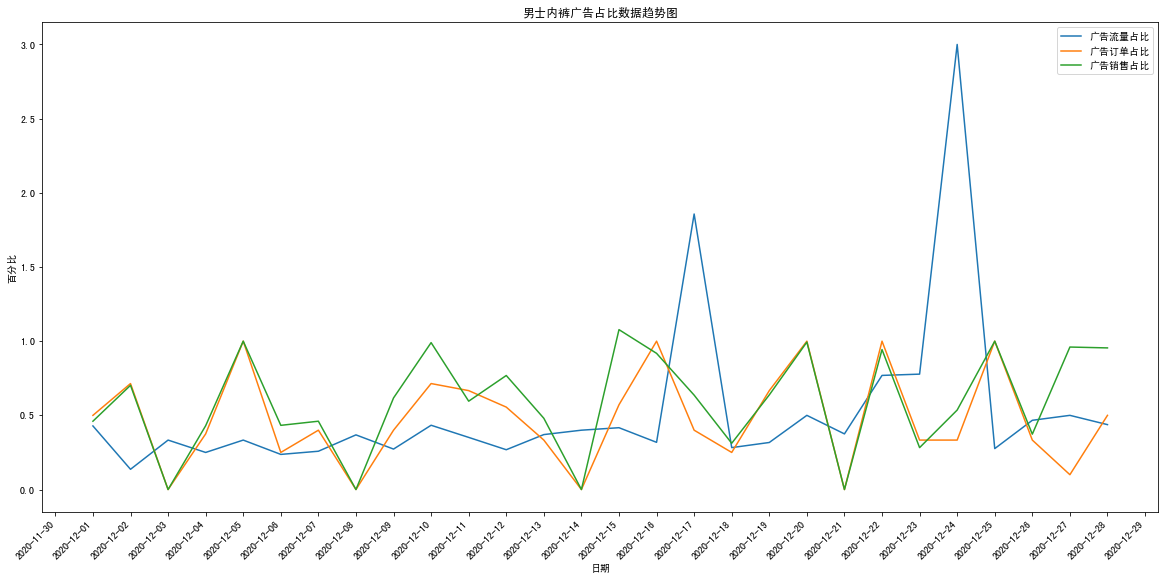

In [22]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['AD Traffic Share'], '广告流量占比'], [statistical_data['AD Order Share'], '广告订单占比'], [statistical_data['AD Sales Share'], '广告销售占比']]
title = '男士内裤广告占比数据趋势图'
ylabel = '百分比'
folded_line(x, y, title, ylabel=ylabel)

## ACoS表现

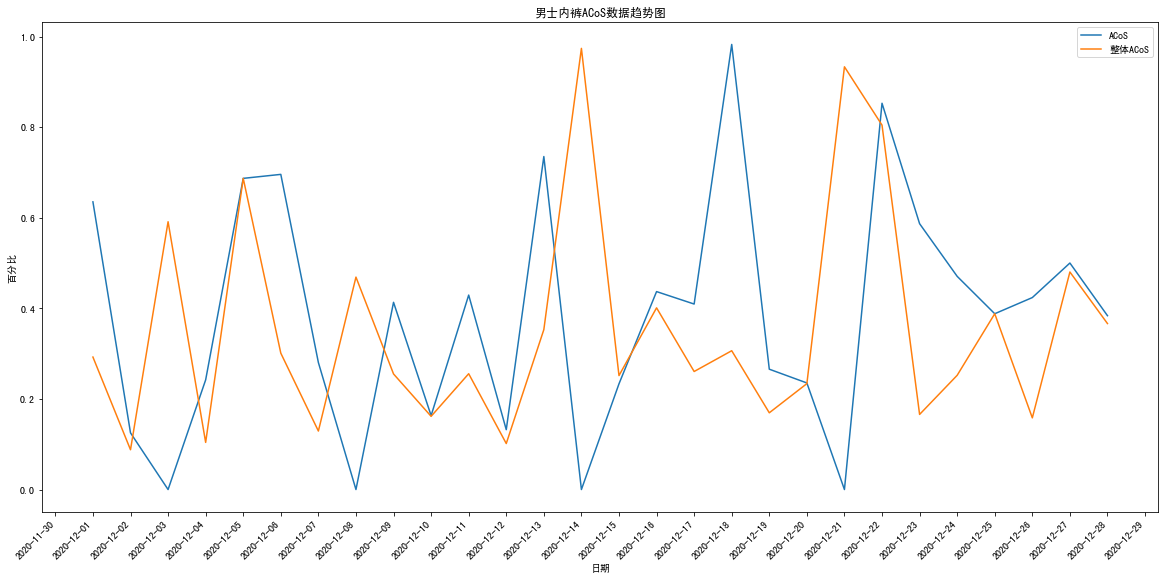

In [24]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['ACoS'], 'ACoS'], [statistical_data['Overall ACoS'], '整体ACoS']]
title = '男士内裤ACoS数据趋势图'
ylabel = '百分比'
folded_line(x, y, title, ylabel=ylabel)

## 转化率情况

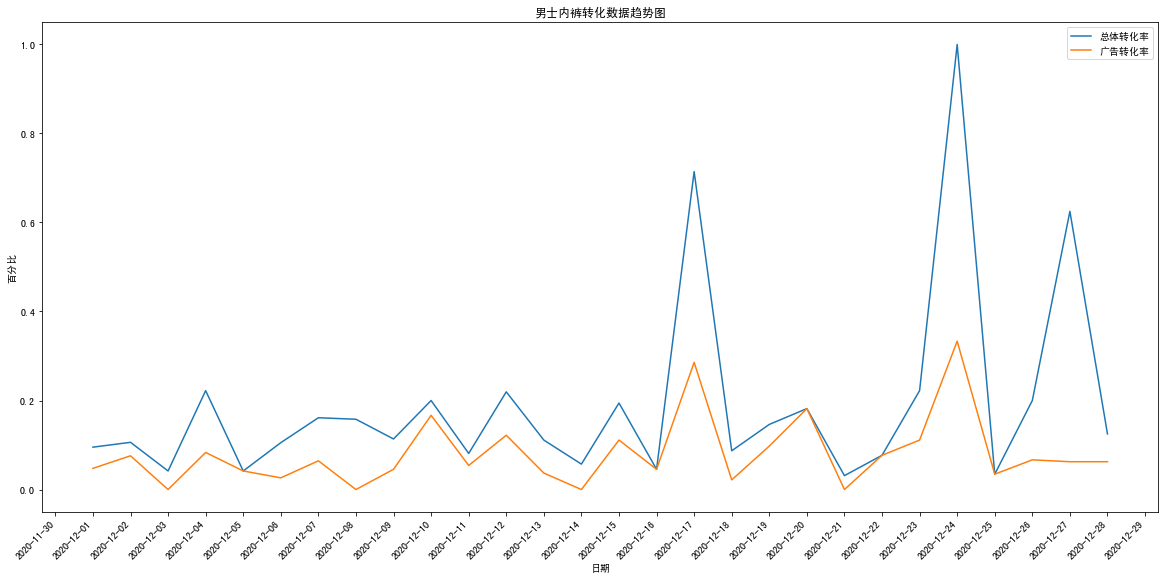

In [25]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['CR'], '总体转化率'], [statistical_data['AD CR'], '广告转化率']]
title = '男士内裤转化数据趋势图'
ylabel = '百分比'
folded_line(x, y, title, ylabel=ylabel)

## 销售额与毛利

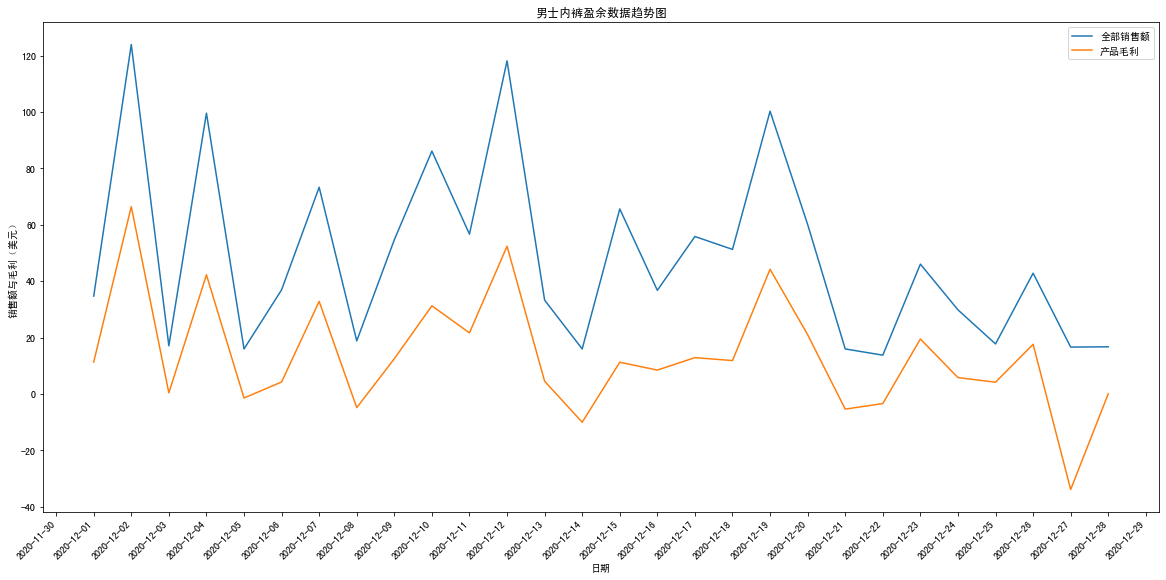

In [27]:
# 作折线图
x = statistical_data['Date']
y = [[statistical_data['Sales']+statistical_data['Sales-B2B'], '全部销售额'], [statistical_data['SAE'], '产品毛利']]
title = '男士内裤盈余数据趋势图'
ylabel = '销售额与毛利（美元）'
folded_line(x, y, title, ylabel=ylabel)

# 订单分析

In [ ]:
流量特征：哪个SKU卖的好、哪个流量高

In [ ]:
订单尺码占比、颜色占比

In [ ]:
顾客区域

In [ ]:
退货情况

# 广告表现

# 库存状况